# Spectroscopic Data Reduction Part 1: Tracing


## Authors
Adam Ginsburg, Kelle Cruz, Lia Corrales, Jonathan Sick, Adrian Price-Whelan

## Learning Goals
* Open a two-dimensional spectrum from an image file (bitmap)
* Fit a spectroscopic trace


## Keywords
Spectroscopy

## Summary
This tutorial will walk through the derivation of a spectroscopic trace model and extraction using astropy tools.

A spectroscopic trace is the path of a point source (star) spectrum through a two-dimensional dispersed spectrum.  The trace is needed because, in general, spectra are not perfectly aligned with the axes of a detector.

# Step 1: Examine the spectrum

We'll work with a 2D spectrum that contains *no* attached metadata, so we have to infer many of the features ourselves.

All we know is that this is a spectrum of a star, Aldebaran.

Our data are in the form of `.bmp` (bitmap) files, so we need PIL (Python Imaging Library) to open them.

While `.bmp` files are not astronomical standard FITS files, as are commonly delivered from professional observatories, image formats like `.bmp`, `.jpg`, `.raw`, `.png`, etc. produced by consumer cameras may also be used for spectroscopy.

In this case, our images are monochromatic, which is similar to standard FITS images.

In [1]:
from PIL import Image
import numpy as np

import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.matplotlib.style.use('dark_background') # Optional!

In [2]:
spectrum_filename = "aldebaran_3s_1.bmp"

In [3]:
image_data = Image.open(spectrum_filename)

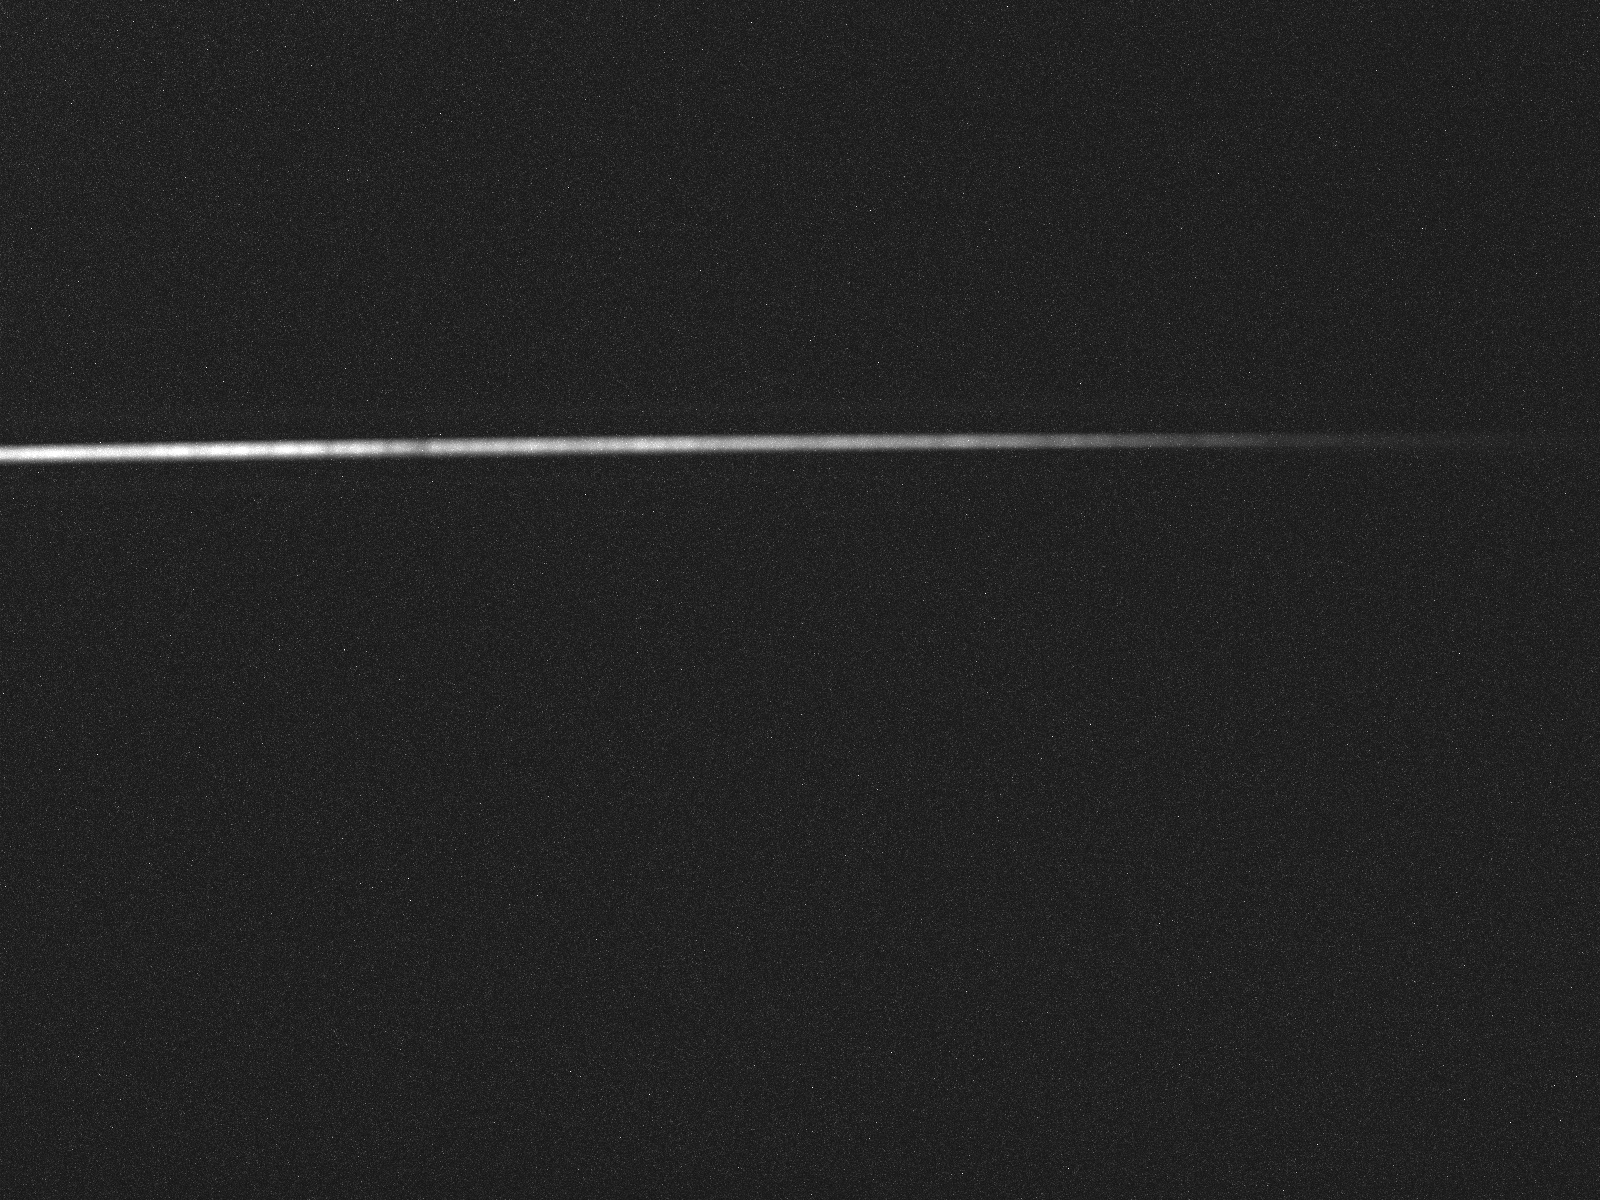

In [4]:
# because this is an image, simply entering on the command line will show it
image_data

In [5]:
# our data are unsigned 8-bit integers (0-255) representing a monochromatic image
# we can see this by printing the array version of the image
# we can also see its shape, verifying that it is indeed 2-dimensional
image_array = np.array(image_data)
image_array, image_array.shape

(array([[41, 43, 50, ..., 52, 28, 27],
        [33, 22, 48, ..., 37, 35, 26],
        [41, 64, 30, ..., 21, 30, 33],
        ...,
        [33, 28, 27, ..., 26, 33, 28],
        [35, 25, 23, ..., 23, 46, 46],
        [32, 35, 22, ..., 23, 40, 29]], dtype=uint8),
 (1200, 1600))

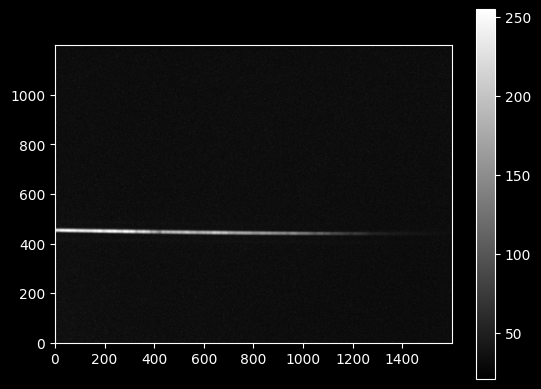

In [6]:
# but we'd like to see it with axes labeled
pl.imshow(image_data, cmap='gray')
pl.colorbar(); # the semicolon at the end of the last line prevents ipython from printing out the object

The main goal of the trace is to obtain a model `f(x)` defining the vertical position of the light (the signal) along the detector.

We're going to start by assuming that wavelength dispersion is in the X-direction and the Y-direction is entirely spatial.  

This is an approximation made by inspecting the image by eye.

# Step 2a. Try to find the spine to trace using argmax

To obtain the trace, we first measure the Y-value at each X-value.  we'll start with the trivial approach of using `argmax`:

In [7]:
yvals = np.argmax(image_data, axis=0)
xvals = np.arange(image_data.width)

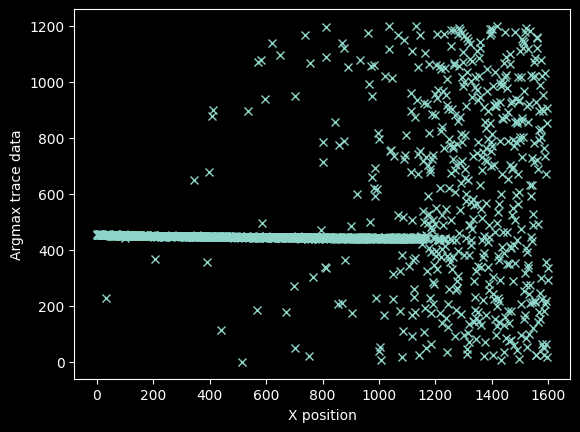

In [8]:
pl.plot(xvals, yvals, 'x')
pl.ylabel("Argmax trace data")
pl.xlabel("X position");

There's a pretty clear line going through the center, which represents our signal, but there are also a lot of erroneous data points.

We can get rid of most of the bad data just by filtering it out using a ``pixel mask``

In [9]:
bad_pixels = (yvals < 400) | (yvals > 500)

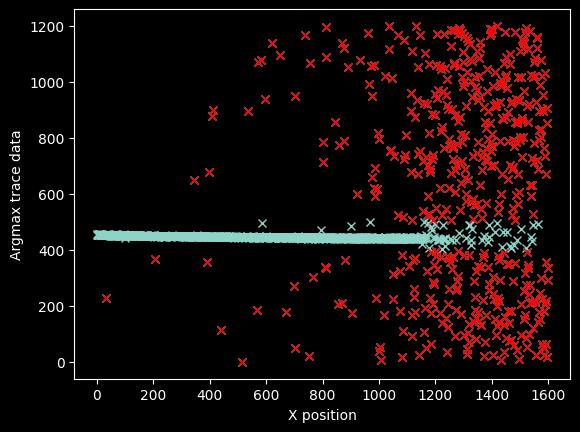

In [10]:
pl.plot(xvals, yvals, 'x')
pl.plot(xvals[bad_pixels], yvals[bad_pixels], 'rx')
pl.ylabel("Argmax trace data")
pl.xlabel("X position");

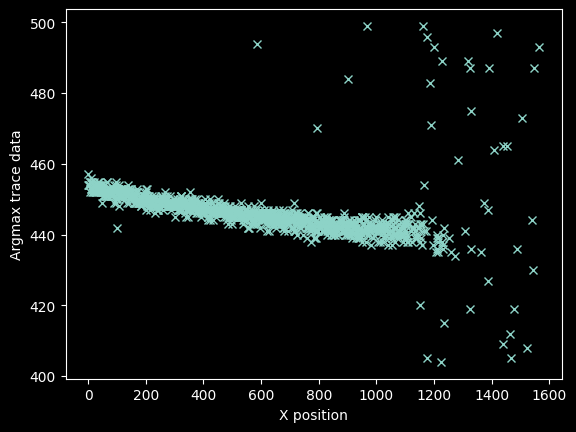

In [11]:
pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], 'x')
pl.ylabel("Argmax trace data")
pl.xlabel("X position");

We can be a little more precise by 'zooming in' along the y-axis, so we refine the mask again to be over a narrower range:

In [12]:
bad_pixels = (yvals < 425) | (yvals > 460)

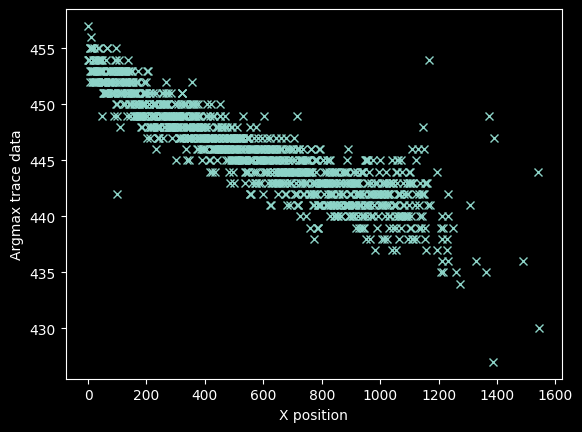

In [13]:
pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], 'x')
pl.ylabel("Argmax trace data")
pl.xlabel("X position");

The stuff at x>1100 looks bad, but there's still signal out there.

We can see there is clear signal out to nearly pixel ~1400:

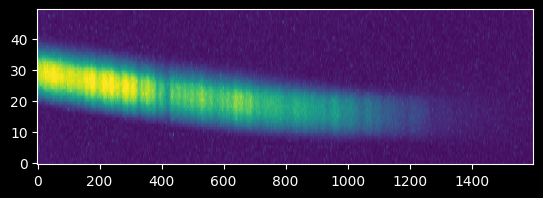

In [14]:
pl.imshow(image_array[425:475,:])
pl.gca().set_aspect(10)

# Step 2b: Use moment analysis to extract a spine to trace

We can use [moments](https://en.wikipedia.org/wiki/Moment_(mathematics)) to provide a different, possibly better, estimate of where the trace's center is.
The advantage of moment analysis is that we're using all of the data to estimate the vertical position, not just the single brightest value, which is what we used above.

Note that we need to subtract off the background to avoid a bias toward the center, so we use the median of the whole image as our background estimate.

(the first-order moment is the intensity-weighted mean position, 
$$m_1 = \frac{\Sigma_i x_i f(x_i)}{\Sigma_i f(x_i)}$$
where $x_i$ is the position and $f({x_i})$ is the intensity at that position.  $f(x_i)$ must be zero in the signal-free region for $m_1$ to return an accurate estimate of the location of the peak)

In [15]:
# we use a cutout around the traced line, so the Y-values are from that cutout
# the `repeat` command here is used to extend our Y-axis position values, which are 425, 426, ... 475
# along the X-direction.  The indexing with [:, None] adds a "dummy" axis along the second (x) dimension,
# then `repeat` copies our Y-axis values.  The resulting array has the same shape as our weight array,
# which is image_array[425:475, :] minus the median
yaxis = np.repeat(np.arange(425, 475)[:,None],
                  image_array.shape[1], axis=1)
background = np.median(image_array)
# moment 1 is the data-weighted average of the Y-axis coordinates
weighted_yaxis_values = np.average(yaxis, axis=0,
                                   weights=image_array[425:475,:] - background)

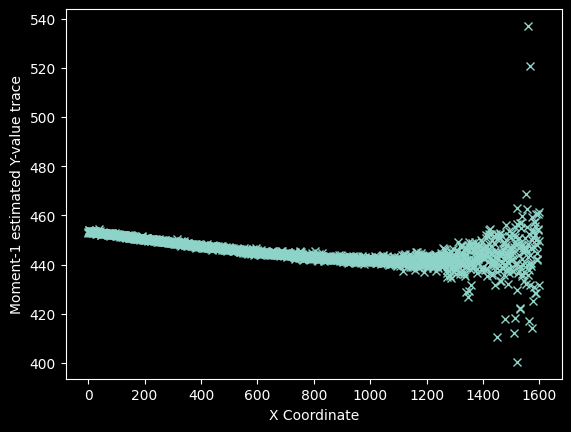

In [16]:
pl.plot(xvals, weighted_yaxis_values, 'x')
pl.xlabel("X Coordinate")
pl.ylabel("Moment-1 estimated Y-value trace");

Overplot the "weighted", centroid locations on the data to verify they look reasonable.

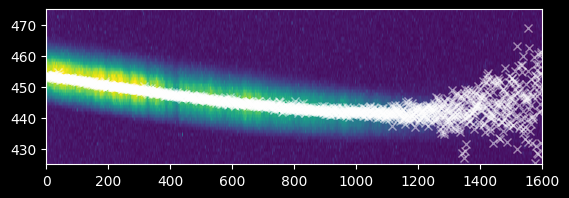

In [17]:
# we need to use the 'extent' keyword to have the axes correctly labeled
pl.imshow(image_array[425:475,:],
          extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10) # we stretch the image out by 10x in the y-direction
pl.plot(xvals, weighted_yaxis_values, 'wx', alpha=0.5)
pl.axis((0,1600,425,475));

We can also compare the argmax and weighted approaches.  They agree well at x<1200, but there are simply more points from the weighted approach at x>1200.

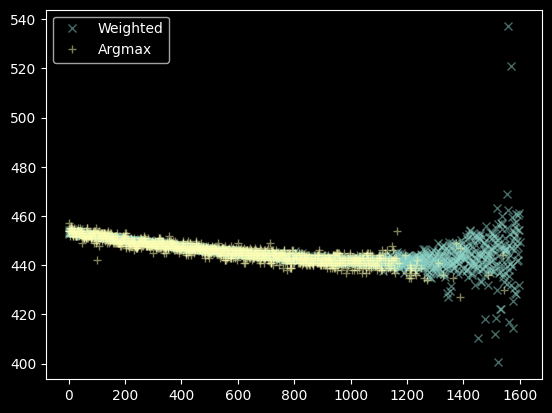

In [18]:
pl.plot(xvals, weighted_yaxis_values, 'x', label="Weighted", alpha=0.5)
pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], '+', label="Argmax", alpha=0.5)
pl.legend(loc='best');

That's a decent set of data, we'll use the moments instead of the argmax.  There's still some data to flag out, though:

In [19]:
bad_moments = (weighted_yaxis_values > 460) | (weighted_yaxis_values < 430)

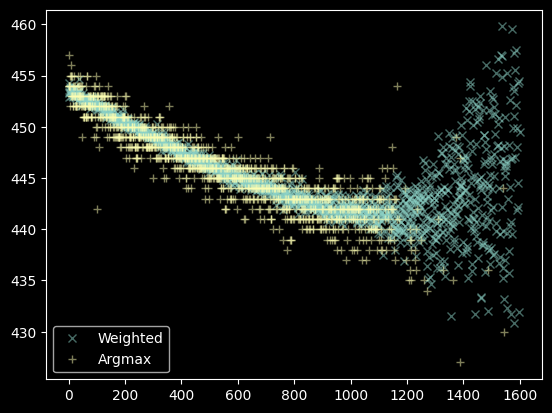

In [20]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x', label="Weighted", alpha=0.5)
pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], '+', label="Argmax", alpha=0.5)
pl.legend(loc='best');

# Step 3. Fit the trace profile

We want a model `f(x)` that gives the y-value of the centroid as a function of x.

In [21]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [22]:
# We fit a 2nd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(polymodel, xvals[~bad_moments], weighted_yaxis_values[~bad_moments])

In [23]:
fitted_polymodel

<Polynomial1D(2, c0=454.80138106, c1=-0.02381282, c2=0.00001121)>

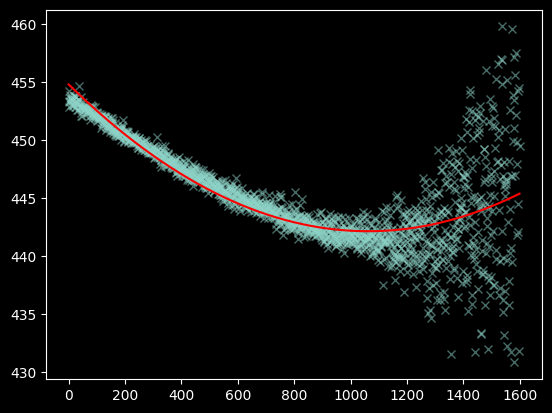

In [24]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x', alpha=0.5)
pl.plot(xvals, fitted_polymodel(xvals), color='r');

We plot and examine the residuals to visually inspect whether the fit is good:

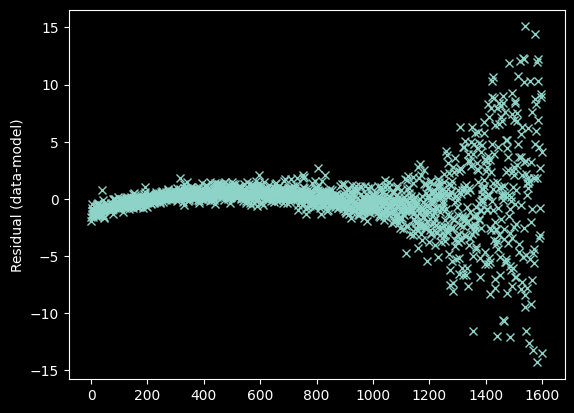

In [25]:
pl.plot(xvals[~bad_moments],
        weighted_yaxis_values[~bad_moments] - fitted_polymodel(xvals[~bad_moments]), 'x')
pl.ylabel("Residual (data-model)");

The curvature seen at the left is a sign of a suboptimal fit.  Specifically, curvature in the residual indicates that we need to use a _higher order_ model - i.e., we need more terms in the polynomial.  We change ``degree=2`` to ``degree=3``.

In [26]:
polymodel = Polynomial1D(degree=3)
fitted_polymodel = linfitter(polymodel, xvals[~bad_moments], weighted_yaxis_values[~bad_moments])
fitted_polymodel

<Polynomial1D(3, c0=453.31622273, c1=-0.01256666, c2=-0.00000651, c3=0.00000001)>

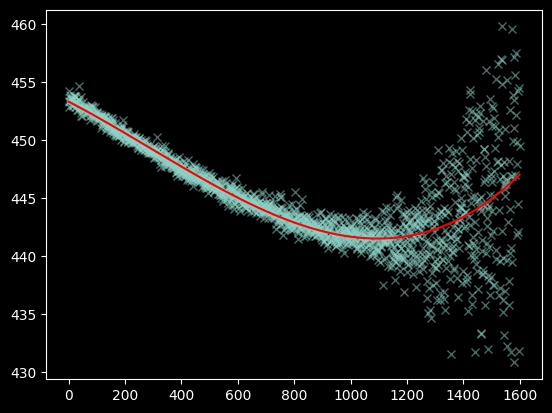

In [27]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x', alpha=0.5)
pl.plot(xvals, fitted_polymodel(xvals), color='r');

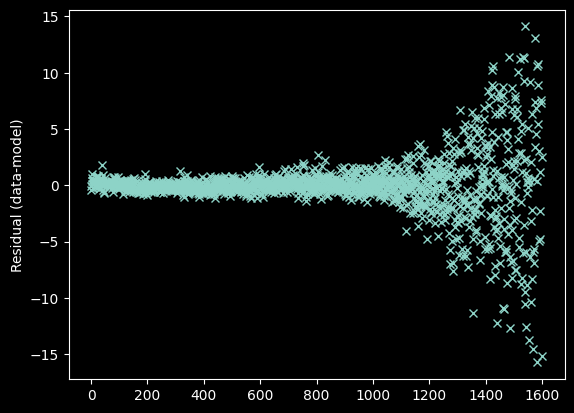

In [28]:
pl.plot(xvals[~bad_moments],
      weighted_yaxis_values[~bad_moments] - fitted_polymodel(xvals[~bad_moments]), 'x')
pl.ylabel("Residual (data-model)");

Arguably, we should toss out the data at >1400 pixels since there's no clear signal there.  We'll come back to this...

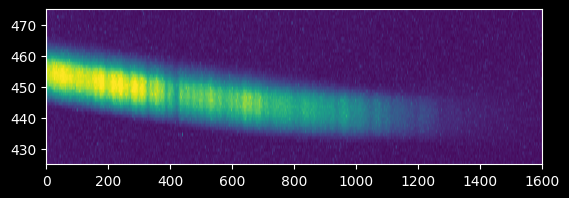

In [29]:
pl.imshow(image_array[425:475,:],
          extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10);

Again, we should verify the trace by overplotting on the original data:

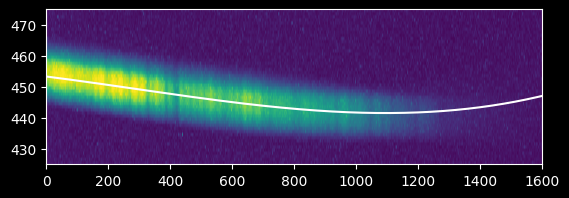

In [30]:
pl.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10)
pl.plot(xvals, fitted_polymodel(xvals), 'w')
pl.axis((0,1600,425,475));

Seeing the curve up in the model to the right - which we do not observe in the data - suggests we should re-fit without including the x>1200 data at all:

In [31]:
polymodel = Polynomial1D(degree=3)
fitted_polymodel = linfitter(polymodel, xvals[(~bad_moments) & (xvals < 1200)],
                             weighted_yaxis_values[(~bad_moments) & (xvals < 1200)])
fitted_polymodel

<Polynomial1D(3, c0=453.63074008, c1=-0.01596396, c2=0.00000083, c3=0.)>

We now have a satisfactory fit:

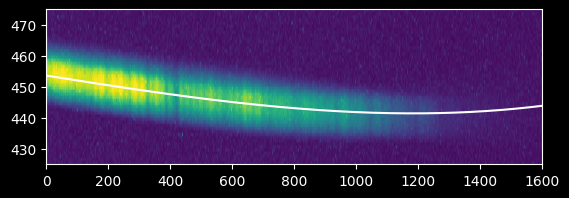

In [32]:
pl.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10)
pl.plot(xvals, fitted_polymodel(xvals), 'w')
pl.axis((0,1600,425,475));

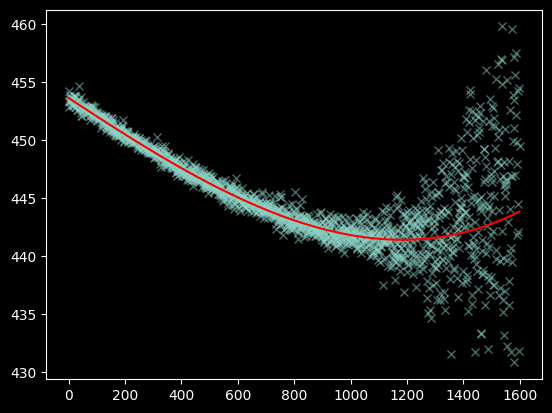

In [33]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x', alpha=0.5)
pl.plot(xvals, fitted_polymodel(xvals), color='r');

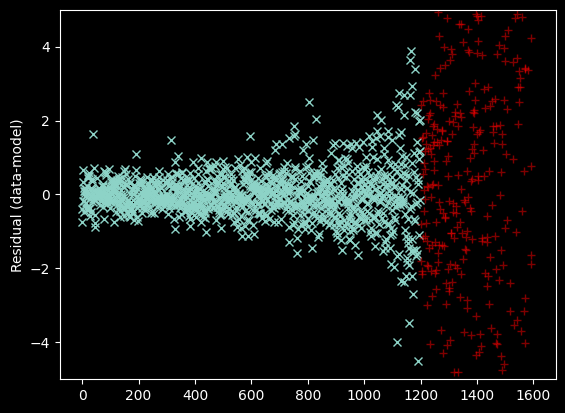

In [34]:
pl.plot(xvals[~bad_moments & (xvals < 1200)],
        weighted_yaxis_values[~bad_moments & (xvals < 1200)] - fitted_polymodel(xvals[~bad_moments & (xvals < 1200)]), 'x')
pl.plot(xvals[~bad_moments & (xvals > 1200)],
        weighted_yaxis_values[~bad_moments & (xvals > 1200)] - fitted_polymodel(xvals[~bad_moments & (xvals > 1200)]), 'r+', alpha=0.5)
pl.ylim(-5, 5)
pl.ylabel("Residual (data-model)");

# Step 4. Obtain a trace profile

Now we can extract the data along that trace.

We want to take a "profile" of the trace to see how many pixels on either side of the line we should include.

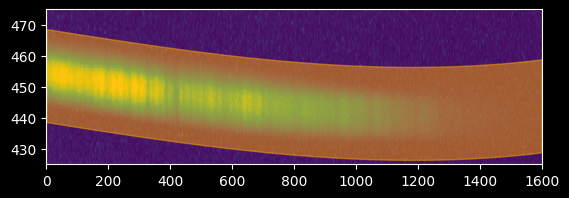

In [35]:
pl.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10)
pl.fill_between(xvals, fitted_polymodel(xvals)-15,
                fitted_polymodel(xvals)+15,
                color='orange', alpha=0.5)
pl.axis((0,1600,425,475));

In [36]:
# start by taking +/- 15 pixels
npixels_to_cut = 15
trace_center = fitted_polymodel(xvals)
cutouts = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])
cutouts.shape

(1600, 30)

That last step deserves some explanation:
```
cutouts = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])
```

* `[... for yval, ii in zip(trace_center, xvals)]` takes each trace y-value and each x-value and 'zips' them together, so each iteration of the for loop has one x, y pair
* `image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]` is taking a single pixel along the x-direction (the second dimension, `ii`) and a range of pixels along the y-direction, i.e., `y+/-n`
* these are put together in a loop, so we have a y+/-n pixel region for each x-pixel
* then we make them all into an array


We can see the result visually:

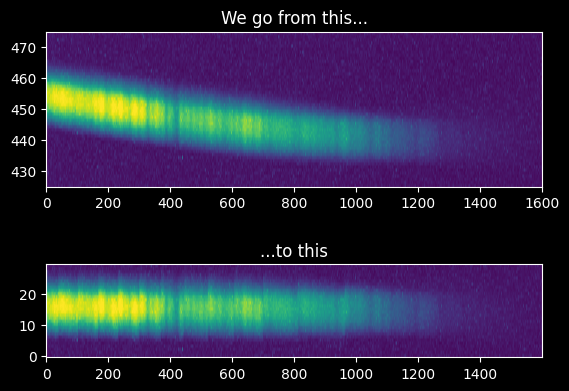

In [37]:
ax1 = pl.subplot(2,1,1)
ax1.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
ax1.set_aspect(10)
ax1.set_title("We go from this...")
ax2 = pl.subplot(2,1,2)
ax2.imshow(cutouts.T)
ax2.set_title("...to this")
ax2.set_aspect(10)

Then we average along the X-direction to get the trace profile:

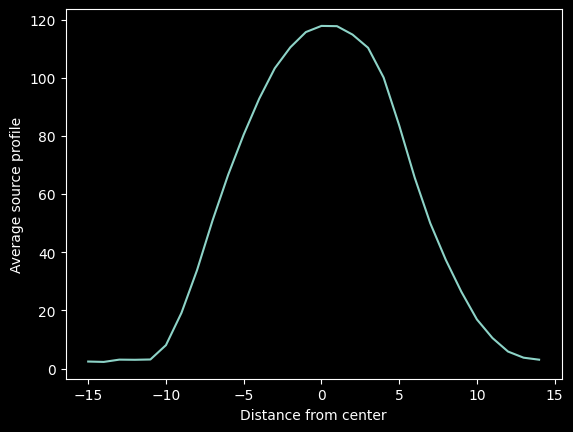

In [38]:
mean_trace_profile = (cutouts - background).mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
pl.plot(trace_profile_xaxis, mean_trace_profile)
pl.xlabel("Distance from center")
pl.ylabel("Average source profile");

We want to fit that profile with a Gaussian for future use,  so we import the Gaussian model profile and non-linear fitter and run a fit:

In [39]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=mean_trace_profile)
model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
fitted_trace_profile

<Gaussian1D(amplitude=123.84846797, mean=0.17719819, stddev=5.10872134)>

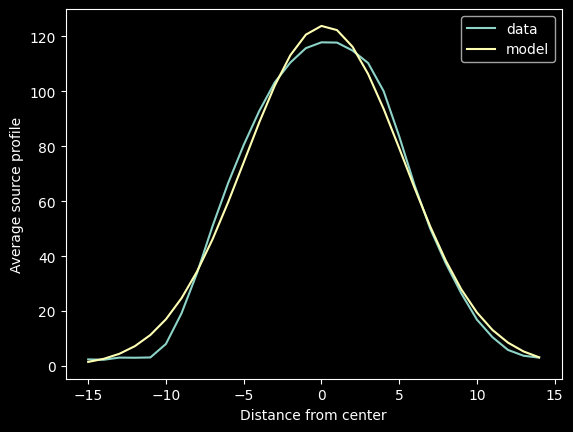

In [40]:
pl.plot(trace_profile_xaxis, mean_trace_profile, label='data')
pl.plot(trace_profile_xaxis, model_trace_profile, label='model')
pl.legend(loc='best')
pl.xlabel("Distance from center")
pl.ylabel("Average source profile");

Both the empirical trace profile `mean_trace_profile` and the modeled `model_trace_profile` can reasonably be used; the latter is more convenient to serialize (i.e., write to disk or on paper)

# Step 5. Extract the traced spectrum

We can obtain our spectrum by directly averaging the pixels along the trace:

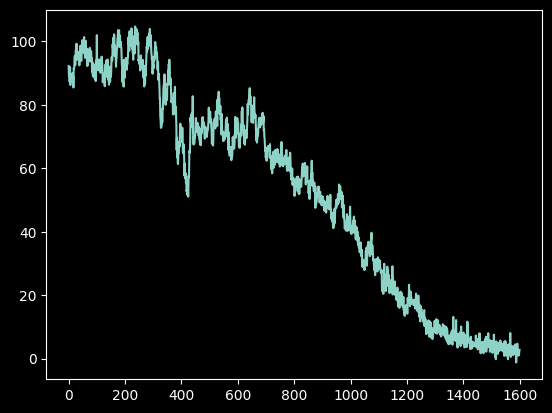

In [41]:
average_spectrum = (cutouts - background).mean(axis=1)
pl.plot(average_spectrum);

Or, we can obtain our spectrum by taking the trace-weighted average:    

In [42]:
trace_avg_spectrum = np.array([np.average(
    image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii] - background,
    weights=mean_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

We can also do this with the Gaussian weights:

In [43]:
gaussian_trace_avg_spectrum = np.array([np.average(
    image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii] - background,
    weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

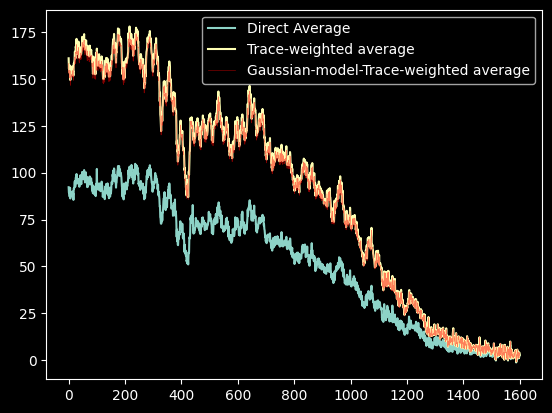

In [44]:
pl.plot(average_spectrum, label="Direct Average")
pl.plot(trace_avg_spectrum, label='Trace-weighted average')
pl.plot(gaussian_trace_avg_spectrum, label='Gaussian-model-Trace-weighted average', alpha=0.5, linewidth=0.5, color='r')
pl.legend(loc='best');

In general, the trace-weighted average will have higher signal-to-noise, as seen here (while we haven't measured the noise, it is approximately constant across the image).

Note that the Gaussian model and the direct trace yield nearly identical results

# Step 6: Repeat for another star

In this last step, we go through all the above steps again for another star (Deneb), but with less explanation.

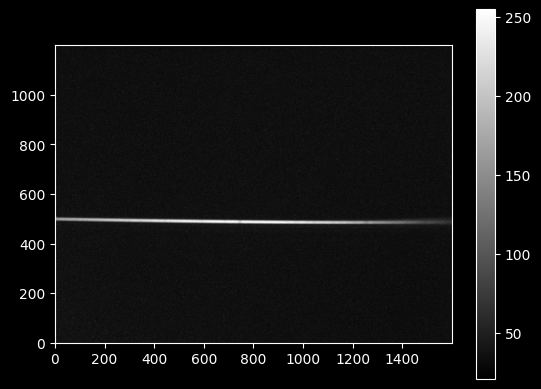

In [45]:
image_array_2 = np.array(Image.open('deneb_3s_13.63g_1.bmp'))
pl.imshow(image_array_2, cmap='gray')
pl.colorbar();

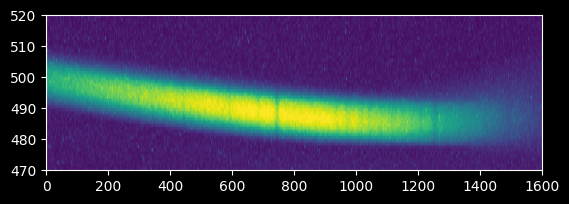

In [46]:
pl.imshow(image_array_2[470:520,:], extent=[0,1600,470,520])
pl.gca().set_aspect(10)

In [47]:
yaxis2 = np.repeat(np.arange(470, 520)[:,None], image_array_2.shape[1], axis=1)
weighted_yaxis_values2 = np.average(yaxis2, axis=0, weights=image_array_2[470:520,:] - np.median(image_array_2))
polymodel2 = Polynomial1D(degree=3)
fitted_polymodel2 = linfitter(polymodel2, xvals, weighted_yaxis_values2)
trace_center2 = fitted_polymodel2(xvals)

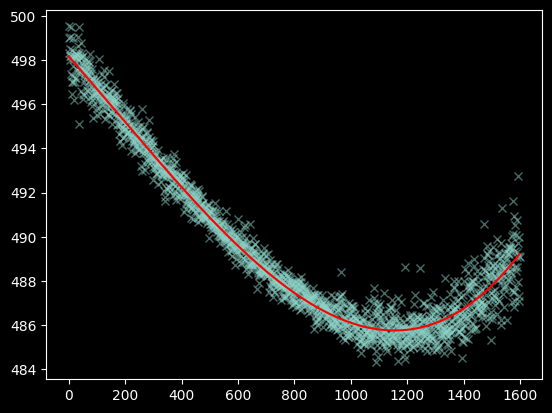

In [48]:
pl.plot(xvals, weighted_yaxis_values2, 'x', alpha=0.5)
pl.plot(xvals, trace_center2, color='r');

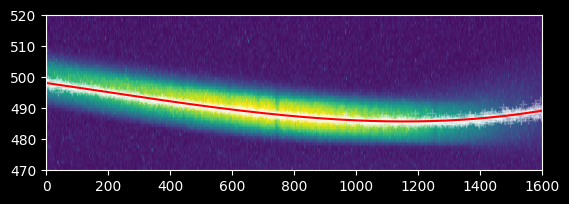

In [49]:
pl.imshow(image_array_2[470:520,:], extent=[0,1600,470,520])
pl.plot(xvals, weighted_yaxis_values2, 'w+', alpha=0.25)
pl.plot(xvals, trace_center2, color='r')
pl.gca().set_aspect(10)

In [50]:
spectrum2 = np.array([np.average(image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii] - np.median(image_array_2),
                                weights=mean_trace_profile)
                     for yval, ii in zip(trace_center2, xvals)])

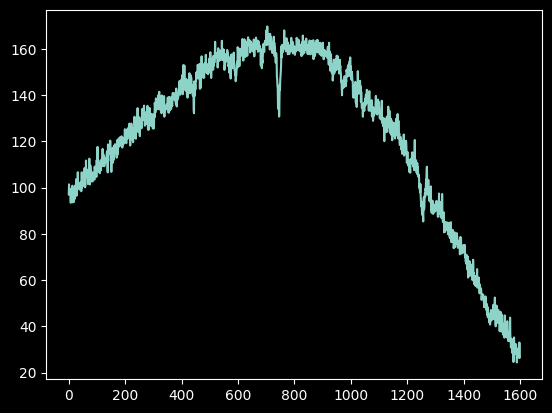

In [51]:
pl.plot(spectrum2);

In the next tutorial, Spectroscopic Data Reduction 2, we'll work on the wavelength calibration.